# Homework 1

* Related with the nature of the data, which conditions should meet matrices $A$ and $b$ to be solvable from the least squares perspective.

* Use a least squares for non-linear models adjust the bitcoin price and perform a prediction using the model to determine the future daily price a week ahead, compare with the actual values.

* Use least squares to determine the relationship between the bitcoin price and prices of three comodities namely, oil, silved and gold, during the last year.

* Solve the [point set registration problem](https://en.wikipedia.org/wiki/Point-set_registration). Hint (check: S. Umeyama, Least-Squares Estimation of Transformation Parameters Between Two Point Patterns, IEEE Trans. Pattern Anal. Mach. Intell., vol. 13, no. 4, 1991). Construct a GUI to test. (**Additional points**)

### 1. Least squares solution $A$ & $b$ conditions 
El problema de ajuste de datos mediante un modelo se puede resolver mediante la minimización de cuadrados de la siguiente forma:

$$\tilde{x} = \mbox{arg min}_{x} \| Ax - b \|_2^2$$ 
En donde la matriz $A$ "codifica" la naturaleza del modelo, $x$ son los parametros y $b$ son las predicciones.

Expandiendo esta expresion e igualando a cero el gradiente(para hallar el minimo de la función) llegamos a la ecuación normal: $$A^T A x = A^T b$$

Ahora bien, ¿Para que $A$ y $b$ tiene solución esta ecuación? 

Si las columnas de $A$ son linearmente independientes, entonces $(A^T A)^{-1}$ existe y la solución se puede calcular mediante $$x = (A^T A)^{-1} A^T b$$¿Es esta solución unica?

Si las columnas de $A$ **NO** son linearmente independientes, entonces la ecuación se puede solucionar mediante descomposición ortogonal, por ejemplo usando descomposición QR o SVD.

Por lo tanto, las ecuaciones normales siempre tienen solución y por lo tanto el problema de los minimos cuadrados lineales es solucionable.

### 2. Linear Least Squares with Non Linear Model
Los datos de Bitcoin fueron tomados de [CryptoDataDownload](https://www.cryptodatadownload.com/data/gemini/).
 
Ahora se va a usar un modelo no lineal para explicar el precio del Bitcoin, especificamente se va modelar mediante un polinomio de grado 5:
$$f(x) = ax^5 + bx^4 + cx^3 + dx^2 + ex + g$$

In [1]:
using CSV
using DataFrames
using Plots
using TimeSeries
using LinearAlgebra

Cargamos los datos del precio del Bitcoin

In [2]:
btc_ds = select(CSV.read("data/Gemini_BTCUSD_day.csv", DataFrame), Not(["Unix Timestamp", "Symbol", "Volume"]))
btc_ds.Date = broadcast(d -> Date(d[1:length(d)-9]), btc_ds.Date) # parse dates
n = 60
btc_ds = btc_ds[1:n,:]; 

In [3]:
first(btc_ds, 5)

,Date,Open,High,Low,Close
,Date,Float64,Float64,Float64,Float64
1,2022-03-17,41025.5,41471.6,40283.1,40592.0
2,2022-03-16,39177.7,41471.6,38950.0,41025.5
3,2022-03-15,38767.4,41702.9,38110.2,39177.7
4,2022-03-14,38167.6,39917.2,38130.8,38767.4
5,2022-03-13,39193.8,39309.1,37578.1,38167.6


Grafica de la serie de tiempo del Bitcoin

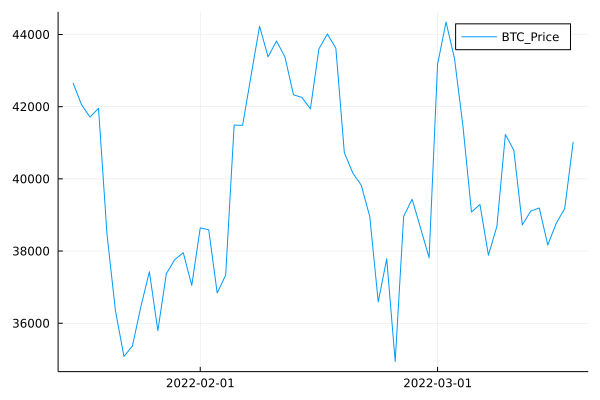

In [4]:
data = (date = btc_ds.Date, BTC_Price = btc_ds.Open)
ta = TimeArray(data; timestamp = :date, meta = "btc")
Plots.plot(ta)

Representación matricial del sistema.

In [5]:
btc_prices = btc_ds.Open
A = [Array(1:n) ones(n,1)] 
b = Array(btc_prices);

Calculo de la solución $ x = (A^T A)^{-1} A^T b$.

In [ ]:
@time inv(transpose(A)*A)*transpose(A)*b

Solución de la ecuación normal $A^T A x = A^T b$ directamente usandoe el operador _backslash_ de Julia.

In [ ]:
@time transpose(A)*A \ transpose(A)*b

Solucion del sistema de ecuaciones sobrecondicionado por LLSQ directamente usando el operador _backslash_.

In [ ]:
@time A \ b

Grafica del modelo lineal.

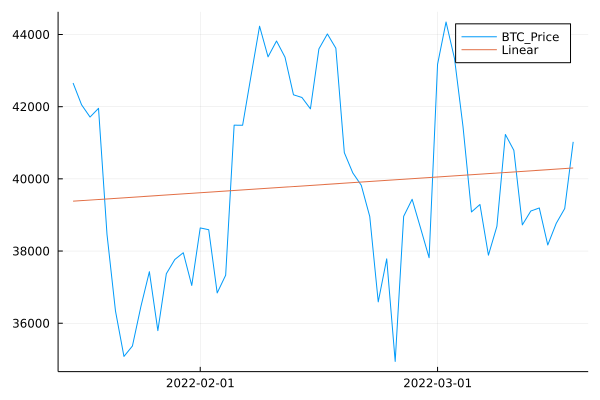

In [6]:
m, b1 = A \ b
pred(x) = m*x + b1
xs = range(1, n)
data = pred.(xs)
plot!(btc_ds.Date, data, label="Linear")

**Polynomial model**

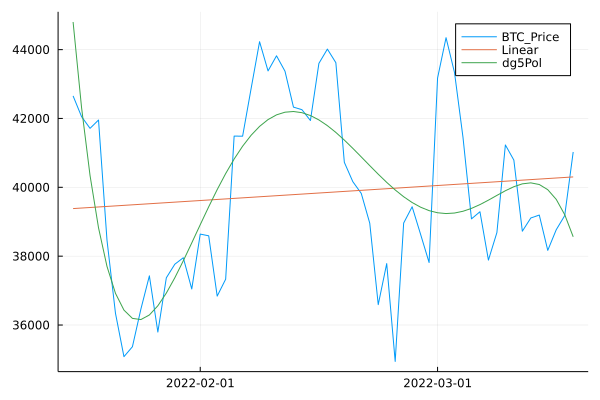

In [7]:
# ax⁵ + bx⁴ + cx³ + dx² + ex + f 
x = Array(1:n)
A = [x.^5 x.^4 x.^3 x.^2 x ones(n)]
a, b, c, d, e, f = A \ b
quint(x) = a*x^5 + b*x^4 + c*x^3 + d*x^2 + e*x + f

xs = range(1, n)
data = quint.(xs)
plot!(btc_ds.Date, data, label="dg5Pol")

Con base en el modelo, ahora podemos predecir el precio del Bitcoin para los proximos 7 dias.

In [8]:
last_date = maximum(btc_ds.Date)
days = [last_date + Dates.Day(i) for i in 1:7]
prices = quint.(Array(36:42))
[days prices]

7×2 Matrix{Any}:
 2022-03-18  42104.5
 2022-03-19  41967.5
 2022-03-20  41769.6
 2022-03-21  41511.2
 2022-03-22  41193.9
 2022-03-23  40821.3
 2022-03-24  40398.6

### 3. BTC relationship with other commodities

Historical data for:

- [**Gold**](https://www.nasdaq.com/market-activity/commodities/gc:cmx/historical) in Troy Oz

- [**Silver**](https://www.nasdaq.com/market-activity/commodities/si:cmx/historical) in Troy Oz

- [**Oil**](https://www.nasdaq.com/market-activity/commodities/cl:nmx/historical) WTI Barrel

In [9]:
# load datasets
btc_ds = select(CSV.read("data/Gemini_BTCUSD_day.csv", DataFrame), Not(["Unix Timestamp", "Symbol", "Volume"]))
gold_ds = select(CSV.read("data/GoldUSD_ds.csv", DataFrame), Not(["Volume"]))
silver_ds = select(CSV.read("data/SilverUSD_ds.csv", DataFrame), Not(["Volume"]))
oil_ds = select(CSV.read("data/OilUSD_ds.csv", DataFrame), Not(["Volume"]))
btc_ds = btc_ds[1:251,:] # last year data

str2date(date) = Date(date, dateformat"m/d/y")

# parse dates
btc_ds.Date = broadcast(d -> Date(d[1:length(d)-9]), btc_ds.Date)
gold_ds.Date = str2date.(gold_ds.Date)
silver_ds.Date = str2date.(silver_ds.Date)
oil_ds.Date = str2date.(oil_ds.Date)

# select open prices
btc_price = btc_ds.Open 
gold_price = gold_ds.Open
silver_price = silver_ds.Open
oil_price = oil_ds.Open;

Graficas del precio del Bitcoin en función del precio del oro, plata y pretróleo.

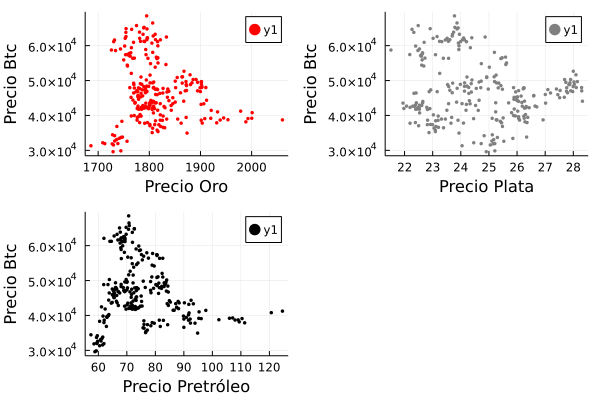

In [10]:
g_plot = plot(gold_price, btc_price,
              seriestype = :scatter,
              markersize = 2,
              markerstrokewidth = 0,
              markercolor = :red,
              xlabel = "Precio Oro",
              ylabel = "Precio Btc") 

s_plot = plot(silver_price, btc_price,
              seriestype = :scatter,
              markersize = 2,
              markerstrokewidth = 0,
              markercolor = :gray, 
              xlabel = "Precio Plata",
              ylabel = "Precio Btc") 

o_plot = plot(oil_price, btc_price,
              seriestype = :scatter,
              markersize = 2,
              markerstrokewidth = 0,
              markercolor = :black, 
              xlabel = "Precio Pretróleo",
              ylabel = "Precio Btc") 

plot(g_plot, s_plot, o_plot)

In [13]:
function LLS(comm, btc)
    n = length(btc)
    A = [comm ones(n)]
    b = btc
    m, b1 = A \ b
    pred(x) = m*x + b1
    return pred.(comm)
end

LLS (generic function with 1 method)

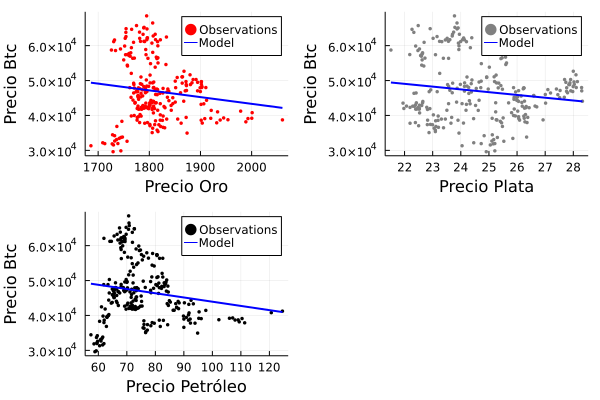

In [18]:
g_plot = plot(gold_price, [btc_price, LLS(gold_price, btc_price)],
              seriestype = [:scatter :line],
              markersize = 2,
              lw = 2,
              linecolor = :blue,
              label = ["Observations" "Model"],
              markerstrokewidth = 0,
              markercolor = :red,
              xlabel = "Precio Oro",
              ylabel = "Precio Btc") 

s_plot = plot(silver_price, [btc_price, LLS(silver_price, btc_price)],
              seriestype = [:scatter :line],
              markersize = 2,
              lw = 2,
              linecolor = :blue,
              label = ["Observations" "Model"],
              markerstrokewidth = 0,
              markercolor = :gray,
              xlabel = "Precio Plata",
              ylabel = "Precio Btc") 

o_plot = plot(oil_price, [btc_price, LLS(oil_price, btc_price)],
              seriestype = [:scatter :line],
              markersize = 2,
              lw = 2,
              linecolor = :blue,
              label = ["Observations" "Model"],
              markerstrokewidth = 0,
              markercolor = :black,
              xlabel = "Precio Petróleo",
              ylabel = "Precio Btc") 

plot(g_plot, s_plot, o_plot)

In [11]:
function gen_PLS(comm, btc, dg)
    n = length(btc)
    A = ones(n,dg+1)
    
    for i in 1:dg
        A[1:n, dg+1-i] = comm.^i
    end
    
    x_hat = A \ btc
    quint(x) = dot(x_hat, [x^i for i in dg:-1:0]) 
    return quint.(comm)
end

gen_PLS (generic function with 1 method)

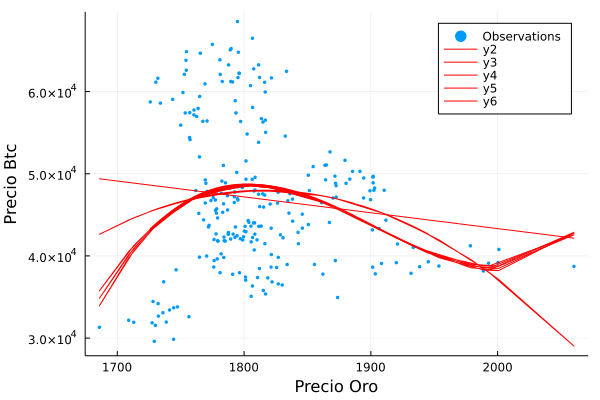

In [12]:
num_models = 5
models = [gen_PLS(gold_price, btc_price, i) for i in 1:num_models]

plot(gold_price, btc_price, seriestype=:scatter, markersize=2, label="Observations", markerstrokewidth=0)

plot!(gold_price, models, 
      markersize = 2,
      markerstrokewidth = 0,
      linecolor = :red,
      xlabel = "Precio Oro",
      ylabel = "Precio Btc",
      lw = 1) 